# 神经网络基础

## 1.相关概念
* 深度学习

    深度学习是机器学习的一个分支，它利用多层神经网络对数据进行非线性变换，从而提高模型的学习能力。

    传统机器学习的流程：输入 -> （人工设计）特征工程 -> 分类 -> 预测

    而深度学习将特征工程交给了算法本身，将特征提取和分类一起进行。
* 神经网络
    
    神经网络是一种模拟人大脑神经元网络的计算模型。它由多个节点（神经元）组成，每个节点接收输入信号，并通过激活函数（如sigmoid、tanh、ReLU等）进行输出。

    神经网络的结构由输入层、隐藏层和输出层组成。输入层接收原始数据，隐藏层（可以有多个）对输入信号进行处理，输出层输出预测结果。

    神经网络的训练过程就是不断调整权重参数，使得神经网络的输出结果逼近真实值。

## 2.激活函数

### 2.1 sigmoid函数
$$ f(x)=\frac{1}{1+e^{-x}} $$

sigmoid函数的特点：

* 可以将任意输入映射到(0,1)之间
* 但是当输入的值<-6或>6时，任何输入值得到的激活值都是差不多的，导致部分信息的丢失
* [-6, 6]范围内的输入值才会有明显差异的输出值，[-3, 3]范围内的输入值才会有比较好的效果
* 一般来说，sigmoid函数在5层之内就会出现梯度消失现象，导致训练不稳定，故实际中使用得较少，一般只用于二分类的输出层

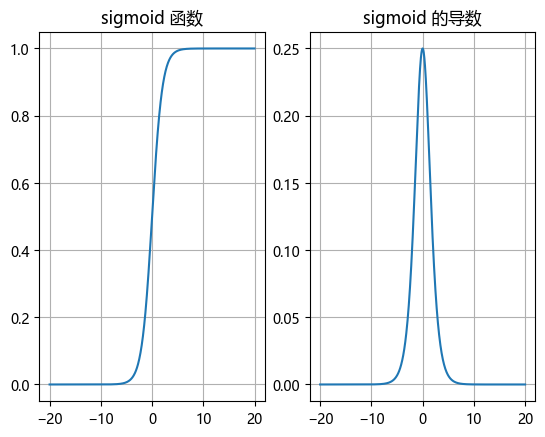

In [4]:
import torch
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2)
# 函数图像
x = torch.linspace(-20, 20, 1000)
y = torch.sigmoid(x)
axes[0].plot(x, y)
axes[0].grid()
axes[0].set_title('sigmoid 函数')
# 导数图像
x = torch.linspace(-20, 20, 1000, requires_grad=True)
torch.sigmoid(x).sum().backward()
axes[1].plot(x.detach(), x.grad)
axes[1].grid()
axes[1].set_title('sigmoid 的导数')
plt.show()

### 2.2 tanh函数
$$ f(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}} $$

tanh函数的特点：

* 可以将任意输入映射到(-1,1)之间，图像关于原点对称
* 输入值<-3或>3时，输出值相差不大，导致部分信息的丢失
* 同样具有梯度消失问题。可以在隐藏层使用tanh函数，输出层使用sigmoid函数

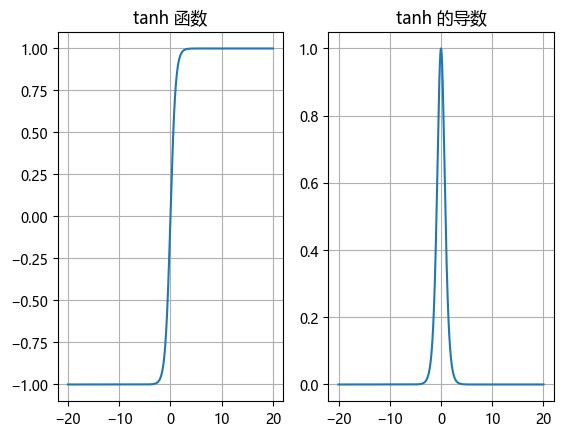

In [6]:
import torch
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2)
# 函数图像
x = torch.linspace(-20, 20, 1000)
y = torch.tanh(x)
axes[0].plot(x, y)
axes[0].grid()
axes[0].set_title('tanh 函数')
# 导数图像
x = torch.linspace(-20, 20, 1000, requires_grad=True)
torch.tanh(x).sum().backward()
axes[1].plot(x.detach(), x.grad)
axes[1].grid()
axes[1].set_title('tanh 的导数')
plt.show()

### 2.3 ReLU函数
$$ f(x)=\max(0,x) $$

ReLU函数的特点：
* ReLU函数将小于0的值映射为0，大于0的值保持不变，更加重视正信号，忽略负信号
* 激活函数简单，能够提高模型训练的效率
* 能够在x>0时保持梯度不衰减，从而缓解了梯度消失问题；然而，随着训练推进，部分输入会落入负区，导致对应权重无法更新，称为“神经元死亡”现象，从而无法完成深层网络的训练
* 一部分神经元的死亡形成了网络的稀疏性，减少了参数的相互依存关系，缓解了过拟合问题的发生

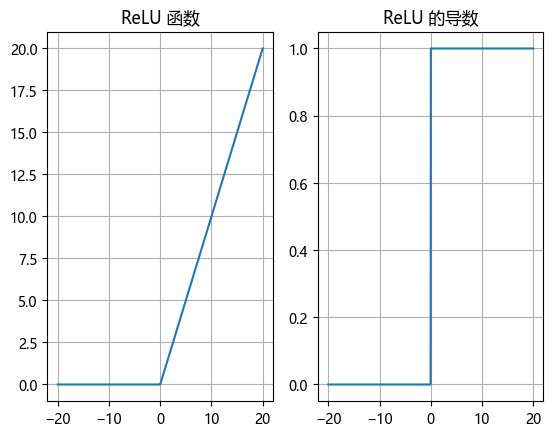

In [7]:
import torch
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2)
# 函数图像
x = torch.linspace(-20, 20, 1000)
y = torch.relu(x)
axes[0].plot(x, y)
axes[0].grid()
axes[0].set_title('ReLU 函数')
# 导数图像
x = torch.linspace(-20, 20, 1000, requires_grad=True)
torch.relu(x).sum().backward()
axes[1].plot(x.detach(), x.grad)
axes[1].grid()
axes[1].set_title('ReLU 的导数')
plt.show()

### 2.4 softmax函数
$$ f(x_i)=\dfrac{e^{x_i}}{\sum_{j} e^{x_j}} $$

softmax函数的特点：
* 将网络输出的scores(或logits)通过softmax函数转换成概率分布
* 输出值总和为1，表示各类别的概率
* 适用于多分类问题，输出层使用softmax函数

In [8]:
scores = torch.tensor([0.2, 0.02, 0.15, 0.15, 1.3, 0.5, 0.06, 1.1, 0.05, 3.75])
proba = torch.softmax(scores, dim=0)
print(proba)

tensor([0.0212, 0.0177, 0.0202, 0.0202, 0.0638, 0.0287, 0.0185, 0.0522, 0.0183,
        0.7392])


### 2.5 其他激活函数
<img src="images/activation.png">

激活函数的选择：
* 对于隐藏层：
    1. 优先选择ReLU函数
    2. 如果效果不好，尝试其他函数如LeakyReLU、ELU、PReLU等
    3. 使用ReLU函数时注意Dead ReLU问题，避免出现大的梯度以致过多神经元死亡
    4. 不要使用sigmoid函数，可以尝试tanh函数
* 对于输出层：
    1. 二分类问题使用sigmoid函数
    2. 多分类问题使用softmax函数
    3. 回归问题使用identity函数

## 3.反向传播

### 3.1 相关概念
* epoch: 一次迭代整个训练集的过程
* batch: 一次训练模型所用的一部分数据
* iteration: 一次更新权重的过程
* 梯度下降的几种方式：

    |    梯度下降方式    |  Training Set Size  |  Batch Size  |       Number of Batches        |
    |:------------:|:-------------------:|:------------:|:------------------------------:|
    |     BGD      |        $ N $        |    $ N $     |               1                |
    |     SGD      |        $ N $        |      1       |             $ N $              |
    |  Mini-Batch  |        $ N $        |    $ B $     | $ \lceil \tfrac{N}{B} \rceil $ |
* 前向传播：数据输入的神经网络中，逐层向前传输，一直到运算到输出层为止。
* 反向传播(Back Propagation)：从输出层开始，逐层向后传输，计算每个节点的误差，并根据误差更新权重。

    设复合函数 $ f(x)=\frac{1}{1+e^{-(wx+b)}} $, 对其中的w和b求偏导，再利用梯度下降公式更新参数
* 注：sigmoid函数导数为 $ f'(x)=f(x)(1-f(x)) $, tanh函数导数为 $ f'(x)=1-f^2(x) $

### 3.2 BP算法

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim


# 搭建网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=2)
        self.linear2 = nn.Linear(in_features=2, out_features=2)
        
        # 网络参数初始化
        self.linear1.weight.data = torch.tensor([
            [0.15, 0.20],
            [0.25, 0.30],
        ])
        self.linear2.weight.data = torch.tensor([
            [0.40, 0.45],
            [0.50, 0.55],
        ])
        self.linear1.bias.data = torch.tensor([0.35, 0.35])
        self.linear2.bias.data = torch.tensor([0.60, 0.60])
        
    # 前向传播
    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x
    
    
inputs = torch.tensor([[0.05, 0.10]])
target = torch.tensor([[0.01, 0.99]])
# 获得网络输出值
net = Net()
output = net(inputs)    # 父类中重写了__call__方法，可以直接使用实例对象调用forward函数
print(output)

# 计算误差
loss = torch.sum((output - target) ** 2) / 2
print(loss)
# 优化方法
optimizer = optim.SGD(net.parameters(), lr=0.5)
# 梯度清零
optimizer.zero_grad()
# 反向传播
loss.backward()
print('-' * 50)
print(net.linear1.weight.grad.data)
print(net.linear2.weight.grad.data)
print('-' * 50)
optimizer.step()
print(net.state_dict())

tensor([[0.7514, 0.7729]], grad_fn=<SigmoidBackward0>)
tensor(0.2984, grad_fn=<DivBackward0>)
--------------------
tensor([[0.0004, 0.0009],
        [0.0005, 0.0010]])
tensor([[ 0.0822,  0.0827],
        [-0.0226, -0.0227]])
--------------------
OrderedDict([('linear1.weight', tensor([[0.1498, 0.1996],
        [0.2498, 0.2995]])), ('linear1.bias', tensor([0.3456, 0.3450])), ('linear2.weight', tensor([[0.3589, 0.4087],
        [0.5113, 0.5614]])), ('linear2.bias', tensor([0.5308, 0.6190]))])


## 4.参数初始化

### 4.1 均匀分布初始化
* 在 $ (-\frac{1}{\sqrt{d}}, \frac{1}{\sqrt{d}}) $ 的均匀分布中生成当前神经元的权重

In [10]:
import torch
import torch.nn as nn

linear = nn.Linear(5, 3)
nn.init.uniform_(linear.weight)
print(linear.weight)

Parameter containing:
tensor([[0.7125, 0.8515, 0.2906, 0.6790, 0.8650],
        [0.2608, 0.5089, 0.0188, 0.5853, 0.6654],
        [0.0331, 0.9160, 0.8433, 0.5693, 0.7027]], requires_grad=True)


### 4.2 正态分布初始化(随机初始化)
* 从均值为0，标准差为1的高斯分布中取样，使用一些很小的值来初始化权重
* c为常数，$\mu$为均值，$\sigma$为标准差
* 权重 $ w \sim N(\mu, \sigma^2) $
* 偏置 $ b \sim N(0, c^2) $

In [14]:
linear = nn.Linear(5, 3)
nn.init.normal_(linear.weight, mean=0, std=1)
print(linear.weight)

Parameter containing:
tensor([[ 0.2295, -1.4882,  0.8085,  0.2356,  0.2683],
        [-0.8133, -2.5897, -0.7433, -0.5266, -0.0082],
        [-0.3305,  0.3793,  0.0051, -0.4876,  0.5271]], requires_grad=True)


### 4.3 全0初始化
* 所有权重参数初始化为0

In [12]:
# 偏置初始化为 0，但是权重不能初始化为 0
linear = nn.Linear(5, 3)
nn.init.zeros_(linear.weight)
print(linear.weight)

Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)


### 4.4 全1初始化
* 所有权重参数初始化为1

In [13]:
linear = nn.Linear(5, 3)
nn.init.ones_(
    linear.weight)
print(linear.weight)

Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)


### 4.5 固定值初始化
* 所有权重参数初始化为一个常数值

In [11]:
linear = nn.Linear(5, 3)
nn.init.constant_(linear.weight, 5)
print(linear.weight)

Parameter containing:
tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.]], requires_grad=True)


### 4.6 kaiming初始化(HE初始化)
* 分为正态分布的HE初始化和均匀分布的HE初始化
* 正态分布的HE初始化：权重 $ w \sim N(0, \frac{2}{n_{in}}) $，偏置 $ b \sim N(0, \frac{1}{n_{in}}) $
* 均匀分布的HE初始化：权重 $ w \sim U(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}}) $，偏置 $ b \sim U(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}}) $

In [15]:
# 正态分布的kaiming初始化
linear = nn.Linear(5, 3)
nn.init.kaiming_normal_(linear.weight)
print(linear.weight)
# 均匀分布的kaiming初始化
linear = nn.Linear(5, 3)
nn.init.kaiming_uniform_(linear.weight)
print(linear.weight)

Parameter containing:
tensor([[ 0.8693,  0.0101, -2.1809, -0.3775, -0.7822],
        [ 0.8481, -0.3324,  0.3536, -0.7460,  0.5360],
        [-1.2750, -1.0852,  1.1090,  0.5988, -0.6298]], requires_grad=True)
Parameter containing:
tensor([[-0.3929,  0.2716,  0.6886, -0.1130, -0.6318],
        [-0.1685, -0.0390,  0.5302,  0.2471, -0.9170],
        [-0.9629,  0.0136, -0.3959,  0.7747,  0.5932]], requires_grad=True)


### 4.7 xaiver初始化(Glorot初始化)
* 各层的激活值和梯度的方差在传播过程中保持一致，分为正态分布的xaiver初始化和均匀分布的xaiver初始化
* 正态分布的xaiver初始化：权重 $ w \sim N(0, \frac{2}{n_{in}+n_{out}}) $，偏置 $ b \sim N(0, \frac{1}{n_{in}+n_{out}}) $
* 均匀分布的xaiver初始化：权重 $ w \sim U(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}}) $，偏置 $ b \sim U(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}}) $

In [ ]:
# 正态分布的xaiver初始化
linear = nn.Linear(5, 3)
nn.init.xavier_normal_(linear.weight)
print(linear.weight)
# 均匀分布的xaiver初始化
linear = nn.Linear(5, 3)
nn.init.xavier_uniform_(linear.weight)
print(linear.weight)


## 5.优化方法
传统梯度下降优化算法中，可能会碰到平缓区域，梯度值较小，参数优化变慢；碰到“鞍点”，即梯度为0，参数无法优化；碰到局部最小值

针对这些问题，需要引入一些优化算法来改善参数更新的过程，使得模型在训练过程中更加稳定、快速、准确。

### 5.1 指数加权平均
$$  S_{t}=\begin{cases}
    Y_{1}, \quad t=0 \\
    \beta S_{t-1}+(1-\beta)Y_t, \quad t>0
\end{cases} $$

其中，$Y_t$为第$t$次迭代的损失函数值，$S_t$为指数加权平均的权重，$\beta$为衰减率。

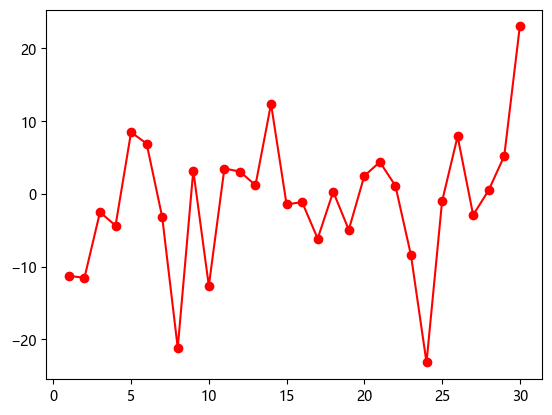

In [16]:
# 1. 没有指数加权平均
# 固定随机种子
torch.manual_seed(0)
# 随机产生30天的温度
temperature = torch.randn(size=[30,]) * 10
# 绘制平均温度值
days = torch.arange(1, 31, 1)
plt.plot(days, temperature, 'o-r')
plt.show()

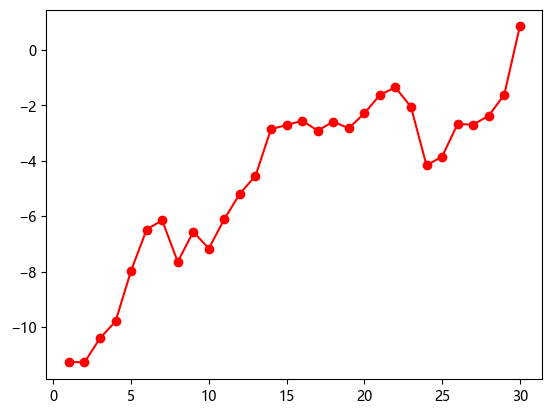

In [20]:
# 2. 指数加权平均
torch.manual_seed(0)
temperature = torch.randn(size=[30,]) * 10
days = torch.arange(1, 31, 1)
# 存储历史指数加权平均值
beta = 0.9
exp_weight_avg = []
for i, temp in enumerate(temperature):
    if i == 0:
        exp_weight_avg.append(temp)
        continue
    new_temp = exp_weight_avg[i - 1] * beta + temp * (1 - beta)
    exp_weight_avg.append(new_temp)
days = torch.arange(1, 31, 1)
plt.plot(days, exp_weight_avg, 'o-r')
plt.show()

### 5.2 动量梯度下降(Momentum)
当梯度下降到“峡谷”“平缓”“鞍点”区域时，参数更新速度变慢。Momentum梯度下降算法通过指数加权平均法，累计历史梯度值，进行参数更新，越近的梯度值对当前参数更新的重要性越大。

<img src="images/momentum.png">



$$ S_{t}=\beta S_{t-1}+(1-\beta)D_{t} $$

其中，$D_t$为当前时刻的动量梯度，$S_t$为历史梯度移动加权平均值，$\beta$为衰减率。

由于Mini-Batch普通的梯度下降算法每次选取少数的样本梯度确定前进方向，可能会出现震荡，使训练时间变长。Momentum使用移动加权平均，平滑了梯度的变化，使得前进方向更加平缓，有利于加快训练过程，一定程度上有利于降低“峡谷”问题的影响。

Momentum算法是对梯度值的一种调整，但并没有对学习率进行优化。

### 5.3 AdaGrad
AdaGrad算法通过对不同的参数分量使用不同的学习率，使得每个学习率总体逐渐变小，这是因为起初离目标的距离较远，可以使用较大的学习率，加快训练速度，随着迭代次数的增加，学习率逐渐下降

1. 初始化学习率 $ \alpha $、初始化参数 $ \theta $、小常数 $ \sigma $ =1e-6
2. 初始化梯度累积变量S = 0
3. 从训练集中采样 $m$ 个样本的小批量，计算梯度 $g$
4. 累计平方梯度 $ s=s+g \odot g $，其中 $ \odot $ 为各个分量相乘

学习率计算公式：$$  \alpha=\frac{\alpha}{\sqrt{s}+\sigma} $$

参数更新公式：$$ \theta=\theta-\frac{\alpha}{\sqrt{s}+\sigma} \cdot g $$

### 5.4 RMSProp
RMSProp算法是AdaGrad算法的改进，对AdaGrad算法的学习率衰减策略进行了改进，用指数移动加权平均替换了历史梯度是平方和。

1. 初始化学习率 $ \alpha $、初始化参数 $ \theta $、小常数 $ \sigma $ =1e-6
2. 初始化梯度累积变量S = 0
3. 从训练集中采样 $m$ 个样本的小批量，计算梯度 $g$
4. 指数移动平均累计历史梯度 $ s= \beta s+(1-\beta)g \odot g $

学习率计算公式：$$  \alpha=\frac{\alpha}{\sqrt{s}+\sigma} $$

参数更新公式：$$ \theta=\theta-\frac{\alpha}{\sqrt{s}+\sigma} \cdot g $$

RMSProp 与 AdaGrad 最大的区别是对梯度的累积方式不同，对于每个梯度分量仍然使用不同的学习率。

RMSProp 通过引入衰减系数 β，控制历史梯度对历史梯度信息获取的多少. 被证明在神经网络非凸条件下的优化更好，学习率衰减更加合理一些。

需要注意的是：AdaGrad 和 RMSProp 都是对于不同的参数分量使用不同的学习率，如果某个参数分量的梯度值较大，则对应的学习率就会较小，如果某个参数分量的梯度较小，则对应的学习率就会较大一些

### 5.5 Adam
Adam 结合了 Momentum、RMSProp 的优点，使用移动加权平均的梯度和移动加权平均的学习率，使得能够自适应学习率的同时，也能够使用 Momentum 的优点。

## 6.正则化
在训练深层神经网络时，由于模型参数较多，在数据量不足的情况下，很容易过拟合。Dropout 就是在神经网络中一种缓解过拟合的方法。

### 6.1 创建和使用 Dropout

In [21]:
import torch
import torch.nn as nn

# 初始化Dropout对象
dropout = nn.Dropout(p=0.8) # 每个神经元有80%的概率被丢弃
# 初始化数据
inputs = torch.randint(0, 10, size=[5, 8]).float()
print(inputs)
# 将 inputs 传入 Dropout 层
outputs = dropout(inputs)
print(outputs)

tensor([[3., 5., 2., 1., 0., 9., 3., 1.],
        [1., 0., 3., 6., 6., 7., 9., 6.],
        [3., 4., 5., 0., 8., 2., 8., 2.],
        [7., 5., 0., 0., 8., 1., 9., 6.],
        [1., 0., 2., 9., 4., 3., 9., 3.]])
tensor([[15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 45., 30.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


### 6.2 Dropout 计算过程
1. 先按照p设置的概率，随机将部分的张量元素设置为0
2. 为了校正张量元素被设置为0带来的影响，需要对非0的元素进行缩放，其缩放因子为：$$ \frac{1}{1-p} $$

### 6.3 Dropout 对网络的影响
Dropout 使部分权重变为0，达到了降低网络复杂度的效果，具有正则化的作用。

In [27]:
torch.manual_seed(0)
# 初始化权重
w = torch.randn(15, 1, requires_grad=True)
# 初始化输入数据
x = torch.randint(0, 10, [5, 15]).float()
# 计算梯度
y = x @ w
y = y.sum()
y.backward()
print(w.grad.reshape(1, -1).squeeze().numpy())

[19. 15. 16. 13. 34. 23. 20. 22. 23. 26. 21. 29. 28. 22. 29.]


In [28]:
torch.manual_seed(0)
w = torch.randn(15, 1, requires_grad=True)
x = torch.randint(0, 10, [5, 15]).float()
# 初始化dropout层
dropout = nn.Dropout(p=0.8)
x = dropout(x)

y = x @ w
y = y.sum()
y.backward()
print(w.grad.reshape(1, -1).squeeze().numpy())

[ 0.  0. 25. 25. 45. 45. 45. 40.  0. 15. 30.  0. 20.  0. 70.]


## 7. 批量归一化(Batch Normalization)
随着网络的深度增加、网络复杂度增加，一般流经网络的数据都是一个 mini batch，每个 mini batch 之间的数据分布变化非常剧烈，这就使得网络参数频繁的进行大的调整以适应流经网络的不同分布的数据，给模型训练带来非常大的不稳定性，使得模型难以收敛。

如果我们对每一个 mini batch 的数据进行标准化之后，数据分布就变得稳定，参数的梯度变化也变得稳定，有助于加快模型的收敛。

### 7.1 批量归一化公式
$$ f(x)=\lambda \cdot \frac{x-E(x)}{\sqrt{Var(x)}+\epsilon}+\beta $$

1. $ \lambda $ 和 $ \beta $ 是可学习的参数，相当于对标准化后的值做了一个线性变换，$\lambda$ 为系数，$\beta$为偏置
2. $\epsilon$通常为1e-5，防止除数为0
3. $E(x)$表示变量的均值
4. $Var(x)$表示变量的方差

数据在经过BN层之后，无论数据以前的分布为什么，都会被归一化为均值为$\beta$，标准差为$\gamma$的分布

注意：BN 层不会改变输入数据的维度，只改变输入数据的的分布. 在实际使用过程中，BN 常常和卷积神经网络结合使用，卷积层的输出结果后接 BN 层。

### 7.2 BN 层的接口

In [32]:
import torch
import torch.nn as nn

# 输入的形状：NCHW [batch_size, channel, height, width]
inputs = torch.randint(0, 10, [1, 2, 3, 3]).float()
print(inputs)
'''
num_features: 输入的通道数，表示每个样本特征图的数量
affine: 是否对 BN 层的可学习参数进行训练(\gamma, \beta)
        affine = False 表示 γ=1，β=0
eps: 小常数，防止除数为0
momentum: 动量因子，用于计算历史均值和方差的指数加权平均值
    running_mean = momentum * running_mean + (1.0 – momentum) * batch_mean
    running_var = momentum * running_var + (1.0 – momentum) * batch_var
'''
bn = nn.BatchNorm2d(num_features=2, affine=True, eps=1e-5)
outputs = bn(inputs)
print(outputs)

tensor([[[[7., 6., 9.],
          [1., 6., 4.],
          [1., 0., 5.]],

         [[2., 5., 8.],
          [1., 8., 1.],
          [2., 8., 0.]]]])
tensor([[[[ 0.9177,  0.5735,  1.6059],
          [-1.1471,  0.5735, -0.1147],
          [-1.1471, -1.4912,  0.2294]],

         [[-0.5944,  0.3496,  1.2937],
          [-0.9091,  1.2937, -0.9091],
          [-0.5944,  1.2937, -1.2237]]]], grad_fn=<NativeBatchNormBackward0>)


## 8. 案例：价格分类

### 8.1 构建数据集